# This Notebook Contains Code that Tests the XGBoost Algorithm to find the best hyperparameters and tests feature importance

### This code is taken from https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ and adapted to our needs... It is a comprehensive guide and is very useful to our cause

In [1]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV  #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

train = pd.read_csv('./data/aggregate_201019.csv')
target = 'reuse'
IDcol = 'project'
train.dropna(inplace=True)
train.pop('maven_release')
train.pop('release')

0        1.0.0
1          0.7
2       2.5.23
3       2.3.14
4       2.5.23
        ...   
425      2.4.8
426      2.6.1
427    1.3.7-3
428    1.4.3-1
429        1.1
Name: release, Length: 270, dtype: object

0        1.0.0
1          0.7
2       2.5.23
3       2.3.14
4       2.5.23
        ...   
425      2.4.8
426      2.6.1
427    1.3.7-3
428    1.4.3-1
429        1.1
Name: release, Length: 270, dtype: object

##### This function is used to fit the model while using cross validation as well, could be used later on for different models, however as of now it is exclusice to XGB

In [2]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='mlogloss', early_stopping_rounds=early_stopping_rounds)
        print(cvresult.shape[0])
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='mlogloss')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    #print(alg)
    #print(alg.booster())
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    #print(feat_imp[::10])
    feat_imp.plot(kind='bar', title='Feature Importances')
    predictors = feat_imp.index.tolist()
    plt.ylabel('Feature Importance Score')
    feat_imp2 = feat_imp.to_frame()
    for predictor in predictors:
        if feat_imp2[0][predictor] <10:
            predictors.remove(predictor)
    return predictors

##### Tuning tree based parameters

In [3]:
def f(x):
    if x['maven_reuse'] < 19: return 0
    elif x['maven_reuse'] < 243 and x['maven_reuse']>=19: return 1
    else: return 2

train['reuse'] = train.apply(f, axis=1)

<AxesSubplot:>

<AxesSubplot:>

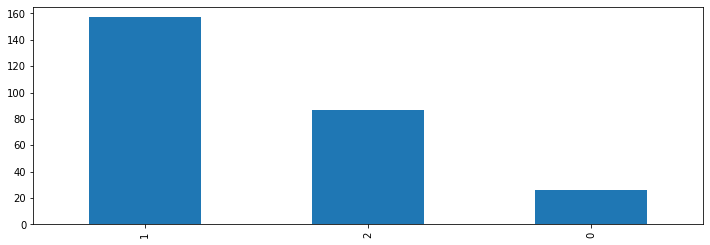

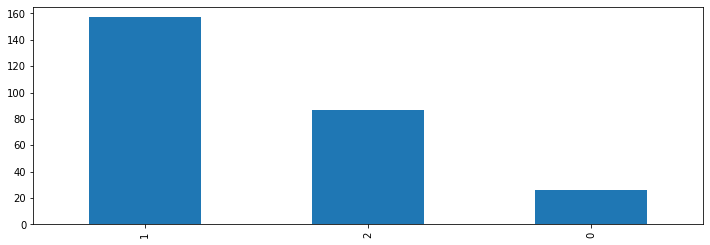

In [4]:
train.reuse.value_counts().plot(kind='bar')

In [5]:
print(corr['maven_reuse'])

NameError: name 'corr' is not defined

NameError: name 'corr' is not defined

In [6]:
train.pop('maven_reuse')


0       23.0
1       49.0
2      208.0
3       31.0
4      135.0
       ...  
425     99.0
426     10.0
427     19.0
428     18.0
429     44.0
Name: maven_reuse, Length: 270, dtype: float64

0       23.0
1       49.0
2      208.0
3       31.0
4      135.0
       ...  
425     99.0
426     10.0
427     19.0
428     18.0
429     44.0
Name: maven_reuse, Length: 270, dtype: float64

In [7]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [8]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]

train[predictors].size


71550

71550

In [9]:
train[target].shape

(270,)

(270,)

In [10]:
train[predictors].shape

(270, 265)

(270, 265)

[16:32:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:32:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:32:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters a

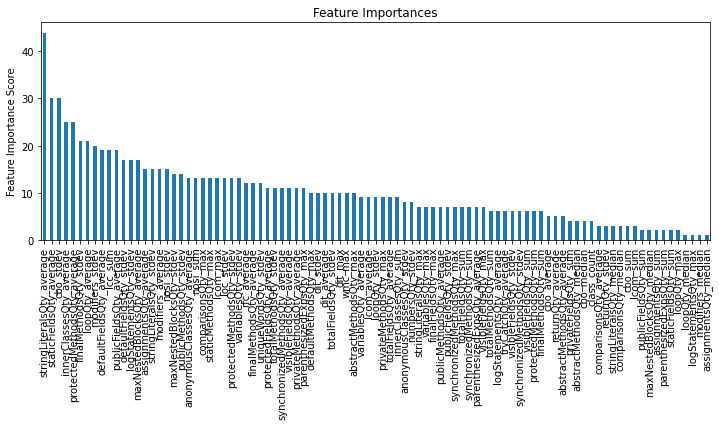

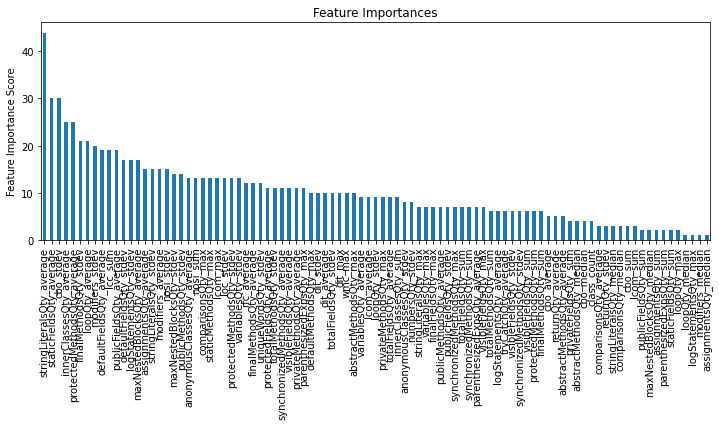

In [12]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softprob',
 num_class = 3,
 nthread=4,
 scale_pos_weight=1,
 seed=27)
predictors = modelfit(xgb1, train, predictors)

##### Tuning max depth and min_child_weight

In [13]:
param_test1 = {
 'max_depth':range(3,10,1),
 'min_child_weight':range(1,6,1)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=25, max_depth=5,
 min_child_weight=1, gamma=0.0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob',num_class=3, nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='neg_log_loss',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.best_params_, gsearch1.best_score_

[16:32:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:32:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'max_depth': 3, 'min_child_weight': 1}, -0.8829455861890757)

({'max_depth': 3, 'min_child_weight': 1}, -0.8829455861890757)

Above we have that 3 and 2 are ideal for depth and child weight, however we will check one above and one below if possible to see whether they are truly optimal

In [14]:
param_test2 = {
 'max_depth': [2, 3, 4, 5],
 'min_child_weight': [1, 2, 3, 4,5]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=25, max_depth=5,
 min_child_weight=2, gamma=0.0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1,seed=27, num_class=3), 
 param_grid = param_test2, scoring='neg_log_loss',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.best_params_, gsearch2.best_score_

[16:33:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:33:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'max_depth': 2, 'min_child_weight': 4}, -0.8745096935166252)

({'max_depth': 2, 'min_child_weight': 4}, -0.8745096935166252)

Above we found max depth 2 and min child weight 4 to be optimal

In [17]:
param_test2b = {
 'min_child_weight':[1, 2,4,6,8,10,12,14,16, 21, 22, 23, 24, 25]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=25, max_depth=2,
 min_child_weight=2, gamma=0.0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1,seed=27, num_class=3), 
 param_grid = param_test2b, scoring='neg_log_loss',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(train[predictors],train[target])

[16:33:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:33:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0.0,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=2, min_child_weight=2,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=25, n_jobs=None, nthread=4,
                                     num_class=3, num_parallel_tree=None,
                                     objective='multi:softprob',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weig

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0.0,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=2, min_child_weight=2,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=25, n_jobs=None, nthread=4,
                                     num_class=3, num_parallel_tree=None,
                                     objective='multi:softprob',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weig

In [18]:
gsearch2b.best_params_, gsearch2b.best_score_

({'min_child_weight': 4}, -0.8745096935166252)

({'min_child_weight': 4}, -0.8745096935166252)

We see 1 as the optimal min child weight

#### Tuning gamma

In [19]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=25, max_depth=2,
 min_child_weight=4, gamma=0.0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1,seed=27, num_class=3), 
 param_grid = param_test3, scoring='neg_log_loss',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])

[16:34:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:34:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0.0,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=2, min_child_weight=4,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=25, n_jobs=None, nthread=4,
                                     num_class=3, num_parallel_tree=None,
                                     objective='multi:softprob',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weig

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0.0,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=2, min_child_weight=4,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=25, n_jobs=None, nthread=4,
                                     num_class=3, num_parallel_tree=None,
                                     objective='multi:softprob',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weig

In [20]:
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.3}, -0.873973843620883)

({'gamma': 0.3}, -0.873973843620883)

We find a gamma of 0.3 as optimal

[16:34:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:34:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:34:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters a

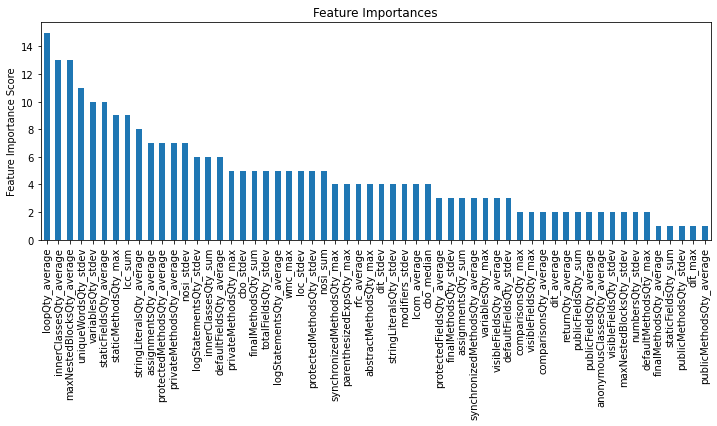

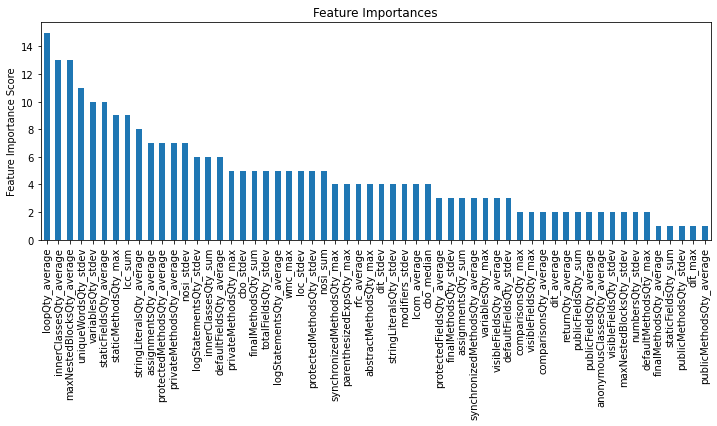

In [21]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=2,
 min_child_weight=4,
 gamma=0.3,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softprob',
 nthread=4,
 scale_pos_weight=1,
 num_class=3,
 seed=27)
predictors = modelfit(xgb2, train, predictors)

In [22]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=34, max_depth=2,
 min_child_weight=4, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1,seed=27, num_class=3), 
 param_grid = param_test4, scoring='neg_log_loss',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.best_params_, gsearch4.best_score_

[16:34:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:34:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'colsample_bytree': 0.8, 'subsample': 0.9}, -0.8397488575566697)

({'colsample_bytree': 0.8, 'subsample': 0.9}, -0.8397488575566697)

In [24]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,95,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=34, max_depth=2,
 min_child_weight=4, gamma=0.3, subsample=0.9, colsample_bytree=0.6,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1,seed=27, num_class=3), 
 param_grid = param_test5, scoring='neg_log_loss',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.best_score_, gsearch5.best_params_

[16:35:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:35:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


(-0.8390341796256877, {'colsample_bytree': 0.75, 'subsample': 0.9})

(-0.8390341796256877, {'colsample_bytree': 0.75, 'subsample': 0.9})

In [25]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=34, max_depth=2,
 min_child_weight=4, gamma=0.3, subsample=0.9, colsample_bytree=0.75,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1,seed=27, num_class=3), 
 param_grid = param_test6, scoring='neg_log_loss',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.best_params_, gsearch6.best_score_

[16:36:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:36:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'reg_alpha': 0.01}, -0.8377881276662704)

({'reg_alpha': 0.01}, -0.8377881276662704)

In [26]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=34, max_depth=2,
 min_child_weight=4, gamma=0.3, subsample=0.9, colsample_bytree=0.75,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1,seed=27, num_class=3), 
 param_grid = param_test7, scoring='neg_log_loss',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])
gsearch7.best_params_, gsearch7.best_score_

[16:36:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:36:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'reg_alpha': 0.01}, -0.8377881276662704)

({'reg_alpha': 0.01}, -0.8377881276662704)

[16:38:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:38:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:38:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters a

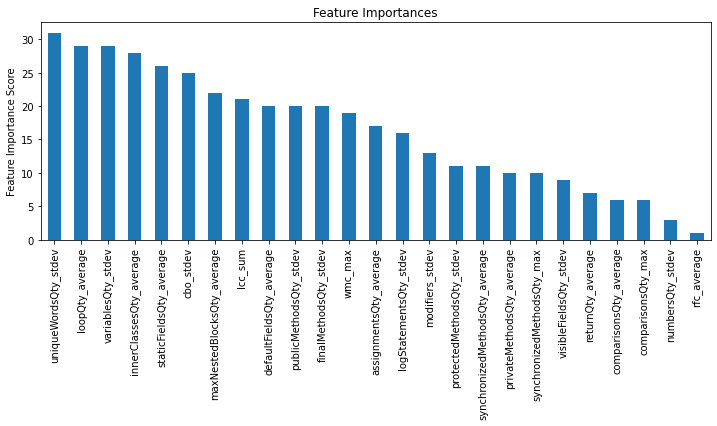

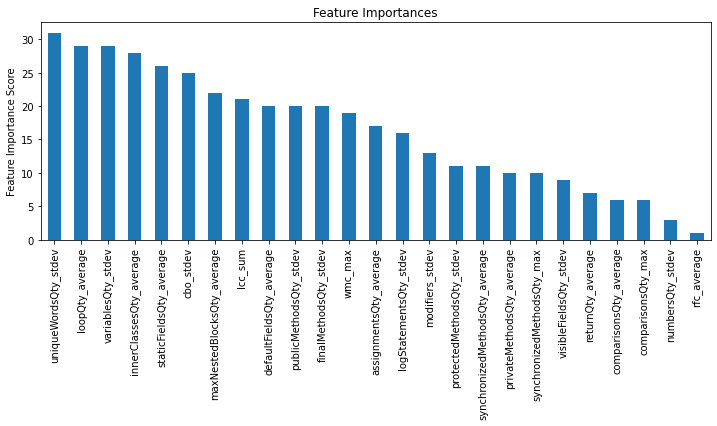

In [30]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=2,
 min_child_weight=4,
 gamma=0.3,
 subsample=0.9,
 colsample_bytree=0.75,
 reg_alpha=0.01,
 objective= 'multi:softprob',
 num_class=3,
 nthread=4,
 scale_pos_weight=1,
 seed=27)
predictors = modelfit(xgb3, train, predictors)

Here we get an accuracy of 84% with 52 n_estimators, 0.9 subsample, 0.75 colsample, gamma 0.3, max_depth 2, min_child = 4

In [31]:
print(len(predictors))

22
22


In [32]:
print(predictors)

['uniqueWordsQty_stdev', 'loopQty_average', 'variablesQty_stdev', 'innerClassesQty_average', 'staticFieldsQty_average', 'cbo_stdev', 'maxNestedBlocksQty_average', 'lcc_sum', 'defaultFieldsQty_average', 'publicMethodsQty_stdev', 'finalMethodsQty_stdev', 'wmc_max', 'assignmentsQty_average', 'logStatementsQty_stdev', 'modifiers_stdev', 'protectedMethodsQty_stdev', 'synchronizedMethodsQty_average', 'privateMethodsQty_average', 'synchronizedMethodsQty_max', 'returnQty_average', 'comparisonsQty_max', 'rfc_average']
['uniqueWordsQty_stdev', 'loopQty_average', 'variablesQty_stdev', 'innerClassesQty_average', 'staticFieldsQty_average', 'cbo_stdev', 'maxNestedBlocksQty_average', 'lcc_sum', 'defaultFieldsQty_average', 'publicMethodsQty_stdev', 'finalMethodsQty_stdev', 'wmc_max', 'assignmentsQty_average', 'logStatementsQty_stdev', 'modifiers_stdev', 'protectedMethodsQty_stdev', 'synchronizedMethodsQty_average', 'privateMethodsQty_average', 'synchronizedMethodsQty_max', 'returnQty_average', 'compar